In [ ]:
##########################
#detection of the entanglement between the
#two quantum registers
#########################

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_histogram
from sympy import factorint
from numpy import linalg
import numpy as np
from numpy import pi
from sympy import *
import random
from random import sample
import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix

In [2]:
import matplotlib.pyplot as plt


In [3]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return y
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 
    

In [4]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix[j][i]=1
             
    for ii in range(N, dim):
        matrix[ii][ii] = 1
             
    matrix = linalg.matrix_power(matrix, 2**power) #possibly dimezzare op. number
        
    U = UnitaryGate(matrix)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [5]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [7]:
N = int(input("Enter integer N = "))

Enter integer N = 15


In [8]:
check(N)

Divisor: a = 5


10

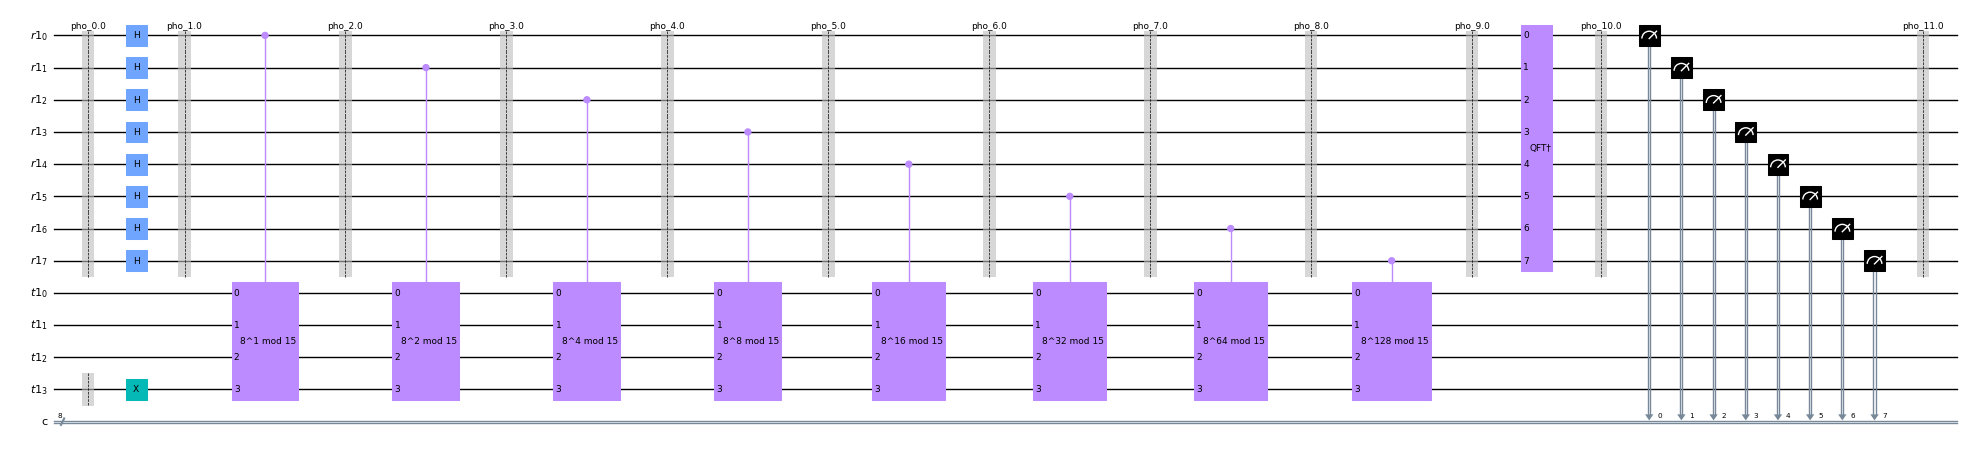

In [13]:
#CALCULATE THE ENT. BETWEEN REGISTERS 
#TRACING AWAY THE TARGET REGISTER
y = 8  
N = 15 
n = math.ceil(math.log(N,2))

control = QuantumRegister(2*n, 'r1')
target  = QuantumRegister(n, 't1')
classic = ClassicalRegister(2*n, 'c')

circuit = QuantumCircuit(control, target, classic)

qubits = control
size = len(qubits)
label = 0
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
circuit.barrier(3*n - 1)

circuit.h(range(2*n))
circuit.x(2*n + n -1)

label += 1

circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

for q in range(2*n):
    label += 1
    circuit.append(mod_exp(n, y, N, q), [q] + [i+2*n for i in range(n)]) 
    circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])
    
circuit.append(qft_dagger(2*n), range(2*n)) 
label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])


circuit.measure(control, classic)
label += 1
circuit.append(SaveDensityMatrix(size, label = f'pho_%.1f' % (label)), [i for i in qubits])

#circuit.draw('latex_source', filename='./circuit.tex', fold = -1, scale = 0.5) 
circuit.draw( fold = -1,output = 'mpl', scale = 0.5) 



In [13]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(circuit, aer_sim)
qobj = assemble(t_qc)                                
results = aer_sim.run(qobj, shots = 1).result()

counts = results.get_counts()

labels = []
for i in range(len(counts)):
    labels.append(   int(list(counts.keys())[i], 2 )   )
    
new_counts = dict(zip(labels,list(counts.values()) ))
#plot_histogram(new_counts)    #output statistics for shots >> 1

In [14]:
entropies = []
for i in range (label+1):
    density_matrix = results.data()['pho_%.1f' % (i)]
    entropies.append(qi.entropy(density_matrix))
    density_matrix = 0

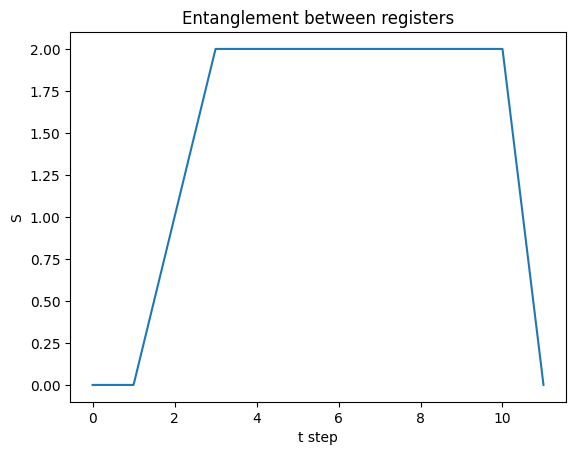

In [15]:
plt.plot(entropies)    
plt.title('Entanglement between registers')
plt.xlabel('t step')
plt.ylabel('S')
#plt.savefig('entropy.pdf', format = 'pdf')
plt.show()

In [16]:
print(entropies)

[1.6017132519074586e-16, 3.032132399974085e-15, 0.9999999999999091, 2.000000000000214, 2.000000000000214, 2.000000000000214, 2.000000000000214, 2.000000000000214, 2.000000000000214, 2.000000000000214, 2.000000000000214, 1.6017132519074586e-16]


In [14]:
import pandas as pd

n_count = 2*n
rows, measured_phases = [], []

for output in counts:
    decimal = int(output, 2)                       # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)                   # Find corresponding eigenvalue
    measured_phases.append(phase)
                                                   # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
                                                   # Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75


In [15]:
from fractions import Fraction

rows = []
period = []

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
    period.append(frac.denominator)

headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4


In [16]:
r = max(period)

guesses = [gcd(y**(r//2)-1, N), gcd(y**(r//2)+1, N)]
print(guesses)

[3, 5]
